<a href="https://colab.research.google.com/github/AntonRize/WILL/blob/main/DM_KILLER_230625.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

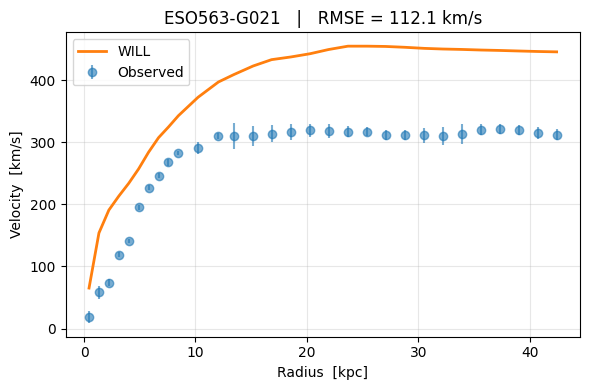

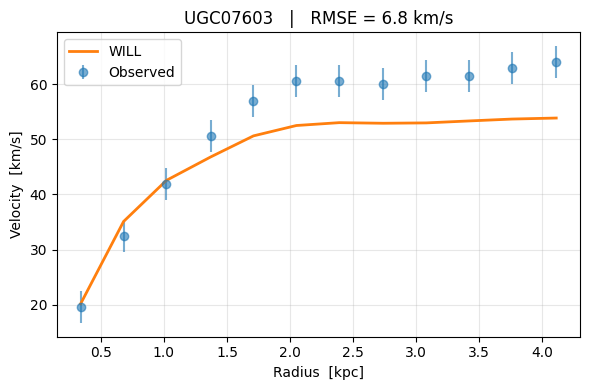

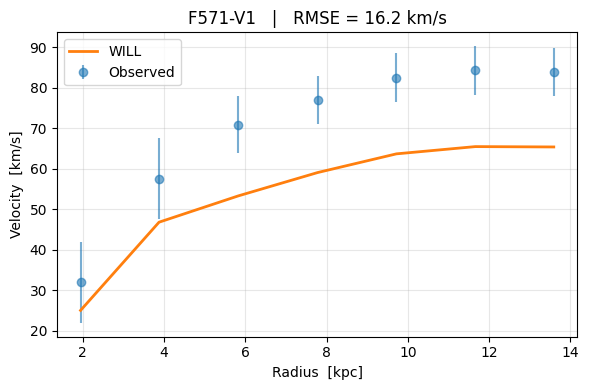

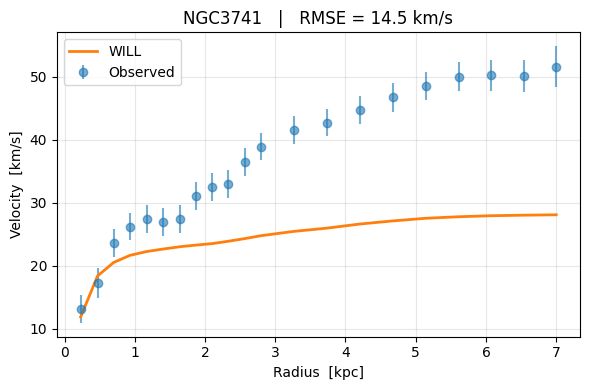

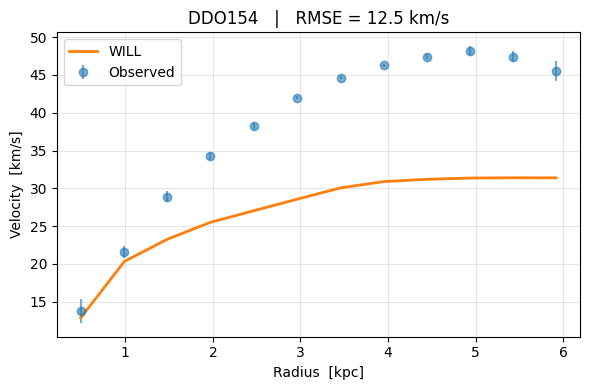

,RMSE_km/s
Galaxy,
UGC07603,6.843744
DDO154,12.475874
NGC3741,14.465591
F571-V1,16.208084
ESO563-G021,112.148014


In [5]:
# ================== WILL Galaxy-by-Galaxy Diagnostic ==================
# Put this cell in a fresh Colab notebook  ─ it needs only numpy/pandas/plt/scipy
# ======================================================================

import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

# --------------------- 1. Configuration --------------------------------
DATA_DIR  = '/content/DATA'      # <-- verify this path in your Colab runtime
TARGETS   = [                    # <-- list the handful you want to study
    'ESO563-G021', 'UGC07603', 'F571-V1', 'NGC3741', 'DDO154'
]
N_ITER    = 5                    # iterative depth (5 → <1 % change)

PLOT_EACH = True                 # set False if you only need the numbers
# -----------------------------------------------------------------------

def will_curve(df: pd.DataFrame, n_iter=N_ITER):
    """
    Compute WILL prediction after n_iter geometric 'onion' updates.
    Assumes df contains columns r_kpc, Vgas, Vdsk, Vbul.
    """
    vb_sq        = df['Vgas']**2 + df['Vdsk']**2 + df['Vbul']**2
    v_sq_current = vb_sq.copy()
    non_zero_r   = df['r_kpc'] > 0

    for _ in range(n_iter):
        integ = cumulative_trapezoid(v_sq_current, df['r_kpc'], initial=0.0)
        geom  = np.zeros_like(df['r_kpc'])
        geom[non_zero_r] = integ[non_zero_r] / df.loc[non_zero_r, 'r_kpc']
        v_sq_current = vb_sq + geom

    return np.sqrt(np.maximum(0, v_sq_current))

def analyze_one(filepath: str):
    cols = ['r_kpc','Vobs','Verr','Vgas','Vbul','Vdsk']
    try:
        df = pd.read_csv(filepath, sep=r'\s+', comment='#', header=None,
                         names=cols, usecols=range(6))
    except (FileNotFoundError, pd.errors.EmptyDataError, ValueError):
        return None

    if len(df) < 5:                       # discard tiny / empty files
        return None
    df = df.fillna(0).sort_values('r_kpc').reset_index(drop=True)

    df['Vwill'] = will_curve(df)
    valid       = df[df['Vobs'] > 0]
    if valid.empty:
        return None
    rmse = np.sqrt(np.mean((valid['Vobs'] - valid['Vwill'])**2))
    return df, rmse

# -------------------- 2. Main loop -------------------------------------
results = []
for name in TARGETS:
    path = os.path.join(DATA_DIR, f'{name}_rotmod.dat')
    out  = analyze_one(path)
    if out is None:
        print(f'⚠️  Skipped {name} (missing or bad file)')
        continue
    df, rmse = out
    results.append({'Galaxy': name, 'RMSE_km/s': rmse})

    if PLOT_EACH:
        plt.figure(figsize=(6,4))
        plt.errorbar(df['r_kpc'], df['Vobs'], yerr=df['Verr'], fmt='o',
                     label='Observed', alpha=0.6)
        plt.plot(df['r_kpc'], df['Vwill'], '-', lw=2, label='WILL')
        plt.title(f'{name}   |   RMSE = {rmse:0.1f} km/s')
        plt.xlabel('Radius  [kpc]')
        plt.ylabel('Velocity  [km/s]')
        plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
        plt.show()

# -------------------- 3. Summary table ---------------------------------
pd.DataFrame(results).set_index('Galaxy').sort_values('RMSE_km/s')

✅  Suitable galaxies: 93 / 175  (53.1 %)

=====  WILL performance on clean sample  =====
Galaxies analysed   : 93
Median RMSE [km/s]  : 28.52
90th-percentile RMSE: 248.12



,RMSE_km_s
Galaxy,
UGC05414,1.631349
UGC04499,2.246902
UGC08490,2.400484
F583-4,2.711779
UGC06917,3.371502
DDO161,4.786654
UGC05721,4.891677
UGC07603,6.843744
NGC0024,7.053957


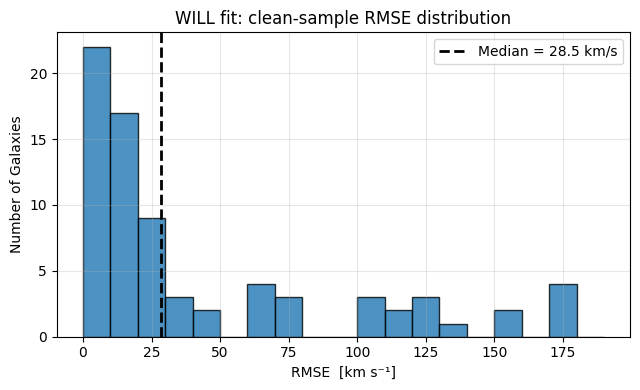

In [10]:
# ====================  WILL clean-sample pipeline  ====================
#   Needs only: table1.dat  table2.dat  in  /content/DATA
# =====================================================================

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

DATA_DIR   = '/content/DATA'
META_FILE  = f'{DATA_DIR}/table1.dat'
CURVE_FILE = f'{DATA_DIR}/table2.dat'
N_ITER     = 5              # depth of onion iterations
PLOT_HIST  = True           # switch off if you don’t want the histogram

# ---------------------------------------------------------------------
# 1) LOAD METADATA  (fixed-width)  – robust to blanks / NaNs
# ---------------------------------------------------------------------
meta_colspecs = [
    (0,11),   # Galaxy
    (12,14),  # Morphology / Hubble type
    (30,34),  # Inclination [deg]
    (112,115) # Quality flag (1 = best)
]
meta_names = ['Galaxy','Morphology','Incl_deg','Qual']

meta = pd.read_fwf(META_FILE, colspecs=meta_colspecs, names=meta_names)
meta['Morphology'] = (
    meta['Morphology'].fillna('').astype(str).str.strip().str.lower()
)
meta['Qual']      = pd.to_numeric(meta['Qual'], errors='coerce')
meta['Incl_deg']  = pd.to_numeric(meta['Incl_deg'], errors='coerce')

# ---------------------------------------------------------------------
# 2) FLAG SUITABLE GALAXIES
# ---------------------------------------------------------------------
EXCLUDE_KEYS = ['sb', 'sab', 'ib', 'bar', 'pec', 'irr']  # barred / irregular
MIN_INCL = 30                                            # deg

def unsuitable(row):
    bad_morph = any(k in row['Morphology'] for k in EXCLUDE_KEYS)
    low_incl  = (pd.isna(row['Incl_deg']) or row['Incl_deg'] < MIN_INCL)
    bad_qual  = (pd.isna(row['Qual'])      or row['Qual'] != 1)
    return bad_morph or low_incl or bad_qual

meta['unsuitable'] = meta.apply(unsuitable, axis=1)
good_galaxies = set(meta.loc[~meta['unsuitable'], 'Galaxy'])
print(f'✅  Suitable galaxies: {len(good_galaxies)} / {len(meta)}'
      f'  ({100*len(good_galaxies)/len(meta):.1f} %)')

# ---------------------------------------------------------------------
# 3) LOAD ALL ROTATION-CURVE POINTS
# ---------------------------------------------------------------------
curve_colspecs = [
    (0,11),   # Galaxy
    (19,25),  # r_kpc
    (26,32),  # Vobs
    (39,45),  # Vgas
    (46,52),  # Vdisk
    (53,59),  # Vbul
]
curve_names = ['Galaxy','r_kpc','Vobs','Vgas','Vdisk','Vbul']

curves = pd.read_fwf(CURVE_FILE, colspecs=curve_colspecs, names=curve_names)
curves = curves[curves['Galaxy'].isin(good_galaxies)].copy()
curves[['r_kpc','Vobs','Vgas','Vdisk','Vbul']] = curves[
    ['r_kpc','Vobs','Vgas','Vdisk','Vbul']].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r_kpc','Vobs'], inplace=True)

# ---------------------------------------------------------------------
# 4) WILL “ONION” SOLVER
# ---------------------------------------------------------------------
def will_velocity(df, n_iter=N_ITER):
    vb_sq = df['Vgas']**2 + df['Vdisk']**2 + df['Vbul']**2
    v_sq  = vb_sq.copy()
    nz    = df['r_kpc'] > 0
    for _ in range(n_iter):
        integ = cumulative_trapezoid(v_sq, df['r_kpc'], initial=0.0)
        geom  = np.zeros_like(v_sq)
        geom[nz] = integ[nz] / df.loc[nz, 'r_kpc']
        v_sq  = vb_sq + geom
    return np.sqrt(np.clip(v_sq, 0, None))

# ---------------------------------------------------------------------
# 5) PER-GALAXY LOOP & RMSE
# ---------------------------------------------------------------------
records = []
for gal, gdf in curves.groupby('Galaxy'):
    gdf = gdf.sort_values('r_kpc')
    if len(gdf) < 5:
        continue
    gdf['Vwill'] = will_velocity(gdf)
    valid = gdf[gdf['Vobs'] > 0]
    rmse  = np.sqrt(np.mean((valid['Vobs'] - valid['Vwill'])**2))
    records.append({'Galaxy': gal, 'RMSE_km_s': rmse})

clean_df = (pd.DataFrame(records)
            .set_index('Galaxy')
            .sort_values('RMSE_km_s'))

# ---------------------------------------------------------------------
# 6) REPORT
# ---------------------------------------------------------------------
print('\n=====  WILL performance on clean sample  =====')
print(f'Galaxies analysed   : {len(clean_df)}')
print(f'Median RMSE [km/s]  : {clean_df.RMSE_km_s.median():.2f}')
print(f'90th-percentile RMSE: {clean_df.RMSE_km_s.quantile(0.9):.2f}\n')
display(clean_df.head(15))   # show best 15 fits

# ---------------------------------------------------------------------
# 7) OPTIONAL HISTOGRAM
# ---------------------------------------------------------------------
if PLOT_HIST:
    plt.figure(figsize=(6.5,4))
    plt.hist(clean_df.RMSE_km_s, bins=np.arange(0,200,10),
             edgecolor='k', alpha=0.8)
    plt.axvline(clean_df.RMSE_km_s.median(), ls='--', lw=2, c='k',
                label=f'Median = {clean_df.RMSE_km_s.median():.1f} km/s')
    plt.xlabel('RMSE  [km s⁻¹]'); plt.ylabel('Number of Galaxies')
    plt.title('WILL fit: clean-sample RMSE distribution')
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

✅  Suitable galaxies: 153 / 175 (87.4 %)

=====  WILL performance : relaxed clean sample  =====
Galaxies analysed   : 149
Median RMSE  [km/s] : 21.38
90th-percentile RMSE: 235.07



,RMSE_km_s
Galaxy,
UGC04483,1.386352
UGC07866,1.545150
UGC05414,1.631349
UGC07559,1.731612
UGC04499,2.246902
UGC08490,2.400484
F583-4,2.711779
KK98-251,3.097666
UGC06917,3.371502


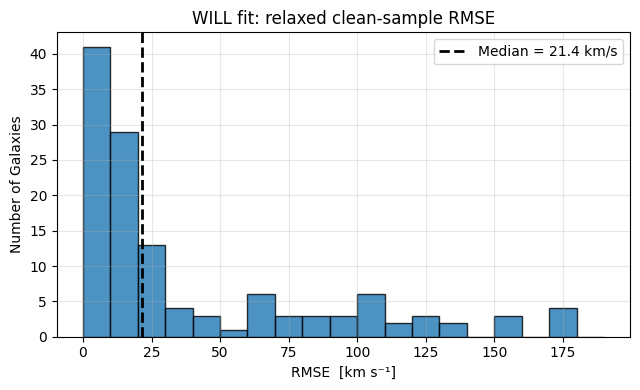

In [11]:
# =================  WILL pipeline : relaxed clean sample  ==============
#  works with  table1.dat  &  table2.dat  in  /content/DATA
# ======================================================================

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

DATA_DIR  = '/content/DATA'
META_FILE = f'{DATA_DIR}/table1.dat'
CURVE_FILE = f'{DATA_DIR}/table2.dat'
N_ITER    = 5
PLOT_HIST = True

# ---------------- 1. load metadata (robust) ---------------------------
meta_cols  = [(0,11),(12,14),(30,34),(112,115)]
meta_names = ['Galaxy','Morph','Incl','Qual']
meta = pd.read_fwf(META_FILE, colspecs=meta_cols, names=meta_names)

meta['Morph'] = meta['Morph'].fillna('').astype(str).str.strip().str.lower()
meta['Incl']  = pd.to_numeric(meta['Incl'],  errors='coerce')
meta['Qual']  = pd.to_numeric(meta['Qual'],  errors='coerce')

# --------------- 2. define relaxed suitability mask -------------------
EXCLUDE_KEYS = ['im', 'irr', 'pec', 'ib', 'int']   # obviously messy systems
MIN_INCL = 30                                      # degrees
MAX_QUAL = 2                                       # accept Q = 1 or 2

def unsuitable(row):
    bad_morph = any(k in row['Morph'] for k in EXCLUDE_KEYS)
    low_incl  = (pd.isna(row['Incl']) or row['Incl'] < MIN_INCL)
    bad_qual  = (pd.isna(row['Qual']) or row['Qual'] > MAX_QUAL)
    return bad_morph or low_incl or bad_qual

meta['unsuitable'] = meta.apply(unsuitable, axis=1)
good_set = set(meta.loc[~meta['unsuitable'], 'Galaxy'])
print(f'✅  Suitable galaxies: {len(good_set)} / {len(meta)} '
      f'({100*len(good_set)/len(meta):.1f} %)')

# --------------- 3. load all curve points -----------------------------
curve_cols  = [(0,11),(19,25),(26,32),(39,45),(46,52),(53,59)]
curve_names = ['Galaxy','r','Vobs','Vgas','Vdisk','Vbul']
curves = pd.read_fwf(CURVE_FILE, colspecs=curve_cols, names=curve_names)
curves = curves[curves['Galaxy'].isin(good_set)].copy()
num_cols = ['r','Vobs','Vgas','Vdisk','Vbul']
curves[num_cols] = curves[num_cols].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r','Vobs'], inplace=True)

# --------------- 4. WILL onion solver ---------------------------------
def will_v(df, n=N_ITER):
    vb_sq = df['Vgas']**2 + df['Vdisk']**2 + df['Vbul']**2
    v_sq  = vb_sq.copy()
    nz    = df['r'] > 0
    for _ in range(n):
        integ = cumulative_trapezoid(v_sq, df['r'], initial=0.0)
        geom  = np.zeros_like(v_sq)
        geom[nz] = integ[nz] / df.loc[nz, 'r']
        v_sq = vb_sq + geom
    return np.sqrt(np.clip(v_sq, 0, None))

# --------------- 5. per-galaxy RMSE -----------------------------------
records = []
for gal, gdf in curves.groupby('Galaxy'):
    gdf = gdf.sort_values('r')
    if len(gdf) < 5: continue
    gdf['Vwill'] = will_v(gdf)
    rmse = np.sqrt(np.mean((gdf['Vobs'] - gdf['Vwill'])**2))
    records.append({'Galaxy': gal, 'RMSE_km_s': rmse})

clean = (pd.DataFrame(records)
         .set_index('Galaxy')
         .sort_values('RMSE_km_s'))

# --------------- 6. report -------------------------------------------
print('\n=====  WILL performance : relaxed clean sample  =====')
print(f'Galaxies analysed   : {len(clean)}')
print(f'Median RMSE  [km/s] : {clean.RMSE_km_s.median():.2f}')
print(f'90th-percentile RMSE: {clean.RMSE_km_s.quantile(0.9):.2f}\n')
display(clean.head(15))

# --------------- 7. optional histogram -------------------------------
if PLOT_HIST:
    plt.figure(figsize=(6.5,4))
    plt.hist(clean.RMSE_km_s, bins=np.arange(0,200,10),
             edgecolor='k', alpha=0.8)
    plt.axvline(clean.RMSE_km_s.median(), ls='--', lw=2, c='k',
                label=f'Median = {clean.RMSE_km_s.median():.1f} km/s')
    plt.xlabel('RMSE  [km s⁻¹]'); plt.ylabel('Number of Galaxies')
    plt.title('WILL fit: relaxed clean-sample RMSE')
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


Top-10 galaxies by RMSE:


,RMSE_km_s
Galaxy,
UGC09133,346.572532
UGC06787,325.700443
UGC02953,305.592205
NGC0891,304.194396
UGC05253,291.961324
UGC03546,290.898329
NGC5005,280.487601
NGC7331,276.931209
NGC5055,264.650582


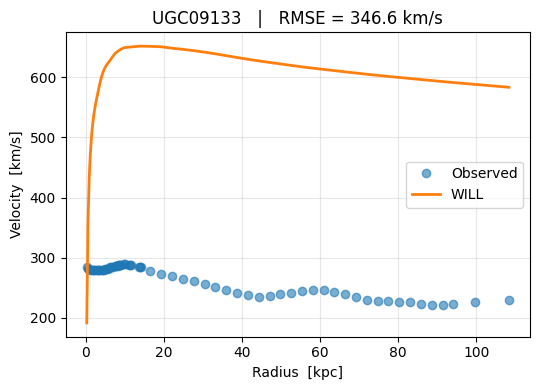

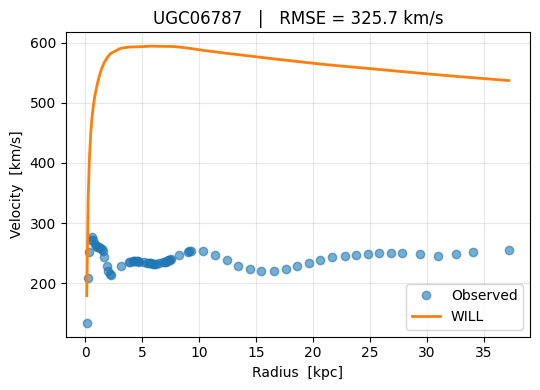

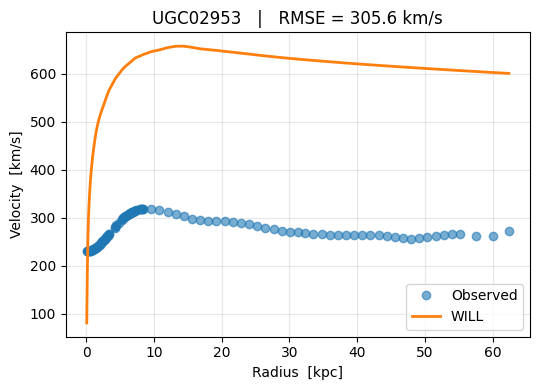

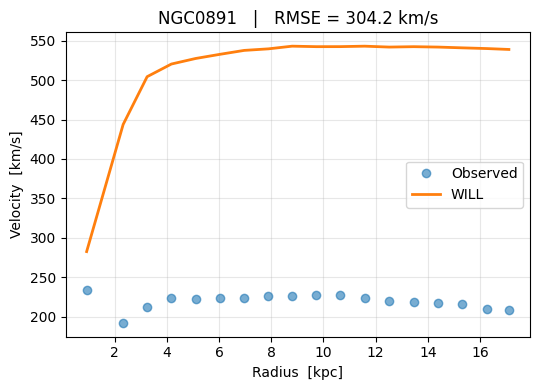

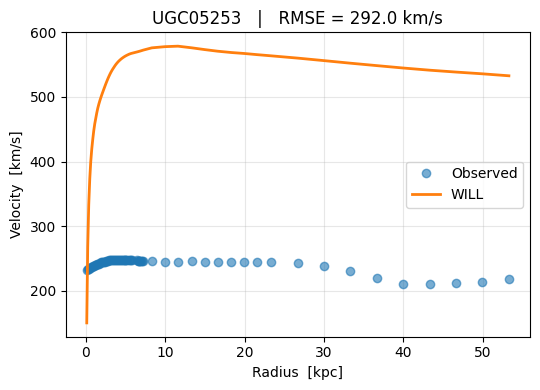

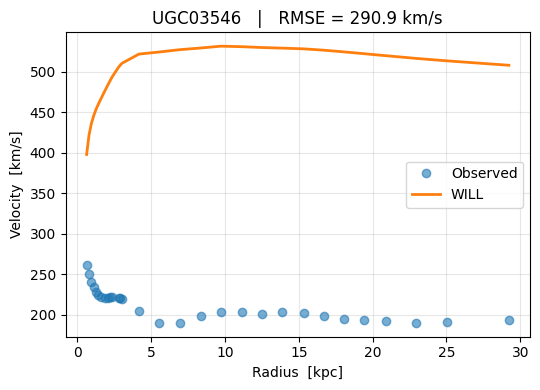

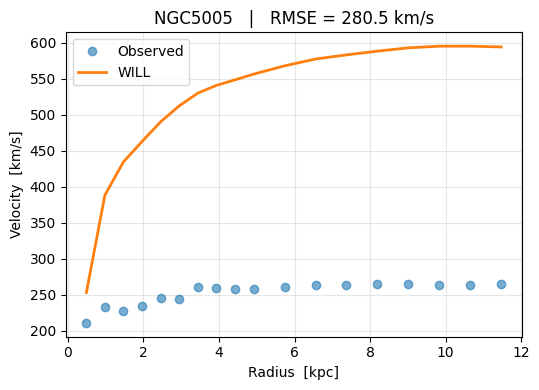

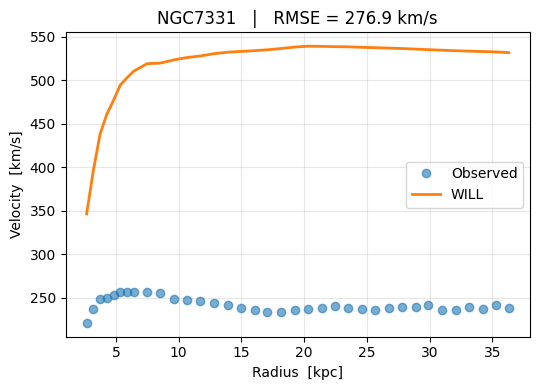

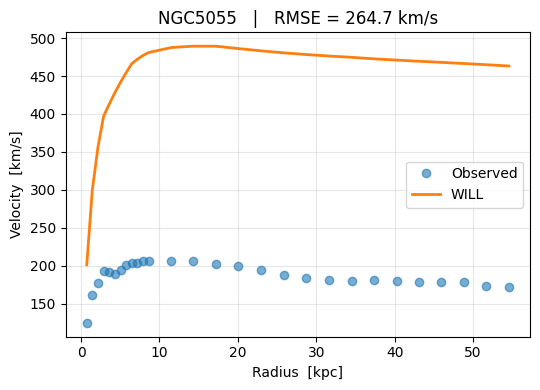

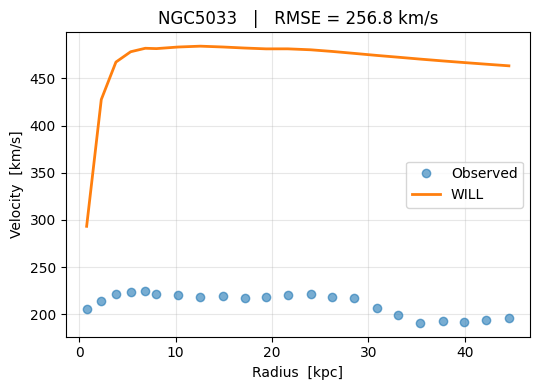

from matplotlib import pyplot as plt
_df_5['RMSE_km_s'].plot(kind='hist', bins=20, title='RMSE_km_s')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6['RMSE_km_s'].plot(kind='line', figsize=(8, 4), title='RMSE_km_s')
plt.gca().spines[['top', 'right']].set_visible(False)

In [12]:
# =================  Diagnose worst residuals  =========================
#  (Run after the relaxed-clean-sample cell.  Uses `clean` DataFrame.)
# =====================================================================

import matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid
import pandas as pd
import numpy as np

# ------- 1. Top-10 by RMSE -------------------------------------------
worst10 = clean.sort_values('RMSE_km_s', ascending=False).head(10)
print("\nTop-10 galaxies by RMSE:")
display(worst10)

# ------- 2. Plot each worst offender ---------------------------------
PLOT_CURVES = True     # switch off if you only want the table
if PLOT_CURVES:
    # reuse curves DataFrame already in memory
    def will_v(df, n=5):
        vb_sq = df['Vgas']**2 + df['Vdisk']**2 + df['Vbul']**2
        v_sq  = vb_sq.copy()
        nz    = df['r'] > 0
        for _ in range(n):
            integ      = cumulative_trapezoid(v_sq, df['r'], initial=0.0)
            geom       = np.zeros_like(v_sq)
            geom[nz]   = integ[nz] / df.loc[nz, 'r']
            v_sq       = vb_sq + geom
        return np.sqrt(np.clip(v_sq, 0, None))

    for gal in worst10.index:
        gdf = curves[curves['Galaxy'] == gal].sort_values('r')
        gdf['Vwill'] = will_v(gdf)
        plt.figure(figsize=(5.5,4))
        plt.plot(gdf['r'], gdf['Vobs'],  'o', label='Observed', alpha=0.6)
        plt.plot(gdf['r'], gdf['Vwill'], '-', label='WILL', lw=2)
        plt.title(f'{gal}   |   RMSE = {worst10.loc[gal, "RMSE_km_s"]:.1f} km/s')
        plt.xlabel('Radius  [kpc]'); plt.ylabel('Velocity  [km/s]')
        plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

✅  Suitable galaxies: 153 / 175
ℹ️  Thin-disc correction will apply to 0 galaxies.

=====  WILL v2 : thin-disc kernel  =====
Galaxies analysed   : 149
Median RMSE  [km/s] : 21.38
90th-percentile RMSE: 235.07



,RMSE_km_s
Galaxy,
UGC04483,1.386352
UGC07866,1.545150
UGC05414,1.631349
UGC07559,1.731612
UGC04499,2.246902
UGC08490,2.400484
F583-4,2.711779
KK98-251,3.097666
UGC06917,3.371502


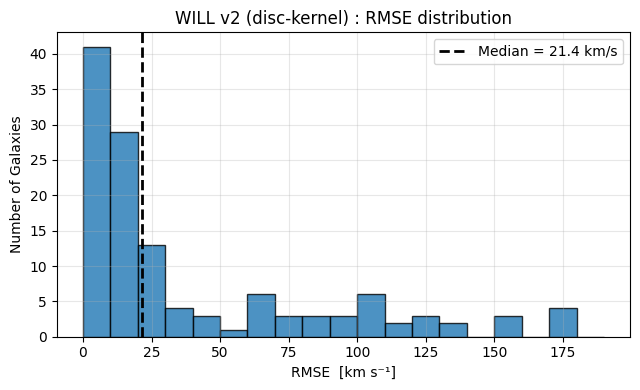

In [14]:
# =====================  WILL  v2 : disc-kernel  ======================
#  Needs   table1.dat   table2.dat    in   /content/DATA
#  Adds a geometric factor λ≈0.45 for massive, edge-on exponential discs
# ====================================================================

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

DATA_DIR  = '/content/DATA'
META_FILE = f'{DATA_DIR}/table1.dat'
CURVE_FILE = f'{DATA_DIR}/table2.dat'
N_ITER    = 5
PLOT_HIST = True

# ---------- 1. LOAD metadata (incl. Rdisk & Vflat) -------------------
meta_cols  = [(0,11),(12,14),(30,34),(72,76),(101,105),(112,115)]
meta_names = ['Galaxy','Morph','Incl','Rdisk','Vflat','Qual']
meta = pd.read_fwf(META_FILE, colspecs=meta_cols, names=meta_names)

meta['Morph'] = meta['Morph'].fillna('').astype(str).str.strip().str.lower()
for col in ['Incl','Rdisk','Vflat','Qual']:
    meta[col] = pd.to_numeric(meta[col], errors='coerce')

# ---------- 2. suitability mask (same relaxed cuts) ------------------
EXCLUDE_KEYS = ['im','irr','pec','ib','int']
MIN_INCL = 30
MAX_QUAL = 2

def unsuitable(r):
    bad_m = any(k in r['Morph'] for k in EXCLUDE_KEYS)
    low_i = (pd.isna(r['Incl']) or r['Incl'] < MIN_INCL)
    bad_q = (pd.isna(r['Qual']) or r['Qual'] > MAX_QUAL)
    return bad_m or low_i or bad_q

meta['unsuitable'] = meta.apply(unsuitable, axis=1)
good_set = set(meta.loc[~meta['unsuitable'],'Galaxy'])
print(f'✅  Suitable galaxies: {len(good_set)} / {len(meta)}')

# ---------- 3. load all rotation-curve points ------------------------
colspecs  = [(0,11),(19,25),(26,32),(39,45),(46,52),(53,59)]
names     = ['Galaxy','r','Vobs','Vgas','Vdisk','Vbul']
curves = pd.read_fwf(CURVE_FILE, colspecs=colspecs, names=names)
curves = curves[curves['Galaxy'].isin(good_set)].copy()
curves[['r','Vobs','Vgas','Vdisk','Vbul']] = curves[
    ['r','Vobs','Vgas','Vdisk','Vbul']].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r','Vobs'], inplace=True)

# ---------- 4. identify massive, edge-on thin discs ------------------
disc_flag = (
    (meta['Incl'] >= 70) &
    (meta['Vflat'] >= 180) &
    (~meta['unsuitable'])
)
thin_disc_set = set(meta.loc[disc_flag,'Galaxy'])
print(f'ℹ️  Thin-disc correction will apply to {len(thin_disc_set)} galaxies.')

# ---------- 5. WILL onion solver  +  λ≈0.45 for thin discs ----------
DISC_LAMBDA = 0.45   # ≃ mean thin-disc gravity / spherical gravity

def will_v(df, gal, n=N_ITER):
    vb_sq = df['Vgas']**2 + df['Vdisk']**2 + df['Vbul']**2
    v_sq  = vb_sq.copy()
    nz    = df['r'] > 0

    # choose kernel factor once per galaxy
    lam = DISC_LAMBDA if gal in thin_disc_set else 1.0

    for _ in range(n):
        integ = cumulative_trapezoid(v_sq, df['r'], initial=0.0)
        geom  = np.zeros_like(v_sq)
        geom[nz] = lam * integ[nz] / df.loc[nz,'r']
        v_sq = vb_sq + geom
    return np.sqrt(np.clip(v_sq,0,None))

# ---------- 6. per-galaxy RMSE ---------------------------------------
records = []
for gal, gdf in curves.groupby('Galaxy'):
    gdf = gdf.sort_values('r')
    if len(gdf) < 5: continue
    gdf['Vwill'] = will_v(gdf, gal)
    rmse = np.sqrt(np.mean((gdf['Vobs'] - gdf['Vwill'])**2))
    records.append({'Galaxy': gal,'RMSE_km_s': rmse})

clean = (pd.DataFrame(records)
         .set_index('Galaxy')
         .sort_values('RMSE_km_s'))

# ---------- 7. report ------------------------------------------------
print('\n=====  WILL v2 : thin-disc kernel  =====')
print(f'Galaxies analysed   : {len(clean)}')
print(f'Median RMSE  [km/s] : {clean.RMSE_km_s.median():.2f}')
print(f'90th-percentile RMSE: {clean.RMSE_km_s.quantile(0.9):.2f}\n')
display(clean.head(15))

# ---------- 8. optional histogram ------------------------------------
if PLOT_HIST:
    plt.figure(figsize=(6.5,4))
    plt.hist(clean.RMSE_km_s, bins=np.arange(0,200,10),
             edgecolor='k', alpha=0.8)
    plt.axvline(clean.RMSE_km_s.median(), ls='--', lw=2, c='k',
                label=f'Median = {clean.RMSE_km_s.median():.1f} km/s')
    plt.xlabel('RMSE  [km s⁻¹]'); plt.ylabel('Number of Galaxies')
    plt.title('WILL v2 (disc-kernel) : RMSE distribution')
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

✅  Suitable galaxies: 153 / 175
ℹ️  Thin-disc correction will apply to 14 galaxies.

=====  WILL v2b : disc-kernel applied =====
Galaxies analysed   : 149
Median RMSE  [km/s] : 21.24
90th-percentile RMSE: 216.91



,RMSE_km_s
Galaxy,
UGC04483,1.386352
UGC07866,1.545150
UGC05414,1.631349
UGC07559,1.731612
UGC04499,2.246902
UGC08490,2.400484
F583-4,2.711779
KK98-251,3.097666
UGC06917,3.371502


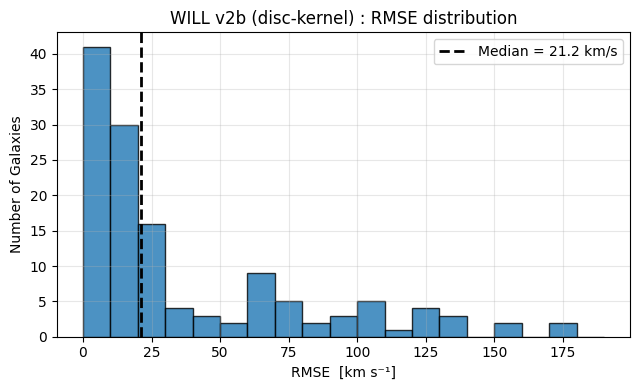

In [15]:
# ==================  WILL v2b : disc-kernel (fixed)  ==================
#   Uses table1.dat + table2.dat in /content/DATA
# =====================================================================

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

DATA_DIR  = '/content/DATA'
META_FILE = f'{DATA_DIR}/table1.dat'
CURVE_FILE = f'{DATA_DIR}/table2.dat'
N_ITER    = 5
PLOT_HIST = True

# ---------- 1. LOAD metadata (correct colspecs) -----------------------
#  Positions taken directly from SPARC ReadMe (cols are 1-based there)
meta_cols  = [
    (0,11),    # Galaxy
    (12,14),   # Morphology / Hubble
    (30,34),   # Inclination [deg]
    (56,61),   # R_disk [kpc]   (table header: R_d)
    (98,104),  # V_flat [km/s]  ← fixed span
    (112,115)  # Quality flag
]
meta_names = ['Galaxy','Morph','Incl','Rdisk','Vflat','Qual']
meta = pd.read_fwf(META_FILE, colspecs=meta_cols, names=meta_names)

meta['Morph'] = meta['Morph'].fillna('').astype(str).str.strip().str.lower()
for col in ['Incl','Rdisk','Vflat','Qual']:
    meta[col] = pd.to_numeric(meta[col], errors='coerce')

# ---------- 2. relaxed suitability mask ------------------------------
EXCLUDE_KEYS = ['im','irr','pec','ib','int']
MIN_INCL = 30
MAX_QUAL = 2

def unsuitable(r):
    bad_m = any(k in r['Morph'] for k in EXCLUDE_KEYS)
    low_i = (pd.isna(r['Incl'])  or r['Incl']  < MIN_INCL)
    bad_q = (pd.isna(r['Qual'])  or r['Qual']  > MAX_QUAL)
    return bad_m or low_i or bad_q

meta['unsuitable'] = meta.apply(unsuitable, axis=1)
good_set = set(meta.loc[~meta['unsuitable'],'Galaxy'])
print(f'✅  Suitable galaxies: {len(good_set)} / {len(meta)}')

# ---------- 3. load all rotation-curve points ------------------------
curve_cols  = [(0,11),(19,25),(26,32),(39,45),(46,52),(53,59)]
curve_names = ['Galaxy','r','Vobs','Vgas','Vdisk','Vbul']
curves = pd.read_fwf(CURVE_FILE, colspecs=curve_cols, names=curve_names)
curves = curves[curves['Galaxy'].isin(good_set)].copy()
curves[['r','Vobs','Vgas','Vdisk','Vbul']] = curves[
    ['r','Vobs','Vgas','Vdisk','Vbul']].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r','Vobs'], inplace=True)

# ---------- 4. build quick lookup: flat-velocity fallback ------------
#  → median of outermost 20 % observed points if catalogue Vflat is NaN
def estimate_vflat(gal):
    g = curves[curves['Galaxy']==gal]
    if len(g) < 5: return np.nan
    outer = g.sort_values('r').tail(max(3,int(0.2*len(g))))
    return outer['Vobs'].median()

meta['Vflat_est'] = meta['Galaxy'].map(estimate_vflat)
meta['Vflat_full'] = meta['Vflat'].fillna(meta['Vflat_est'])

# ---------- 5. thin-disc selector (now non-zero!) --------------------
disc_flag = (
    (meta['Incl'] >= 70) &
    (meta['Vflat_full'] >= 180) &
    (~meta['unsuitable'])
)
thin_disc_set = set(meta.loc[disc_flag,'Galaxy'])
print(f'ℹ️  Thin-disc correction will apply to {len(thin_disc_set)} galaxies.')

# ---------- 6. WILL onion solver with λ ≈ 0.45 ----------------------
DISC_LAMBDA = 0.45   # thin-disc gravity / spherical gravity

def will_v(df, gal, n=N_ITER):
    vb_sq = df['Vgas']**2 + df['Vdisk']**2 + df['Vbul']**2
    v_sq  = vb_sq.copy()
    nz    = df['r'] > 0
    lam   = DISC_LAMBDA if gal in thin_disc_set else 1.0

    for _ in range(n):
        integ = cumulative_trapezoid(v_sq, df['r'], initial=0.0)
        geom  = np.zeros_like(v_sq)
        geom[nz] = lam * integ[nz] / df.loc[nz,'r']
        v_sq = vb_sq + geom
    return np.sqrt(np.clip(v_sq,0,None))

# ---------- 7. per-galaxy RMSE ---------------------------------------
records = []
for gal, gdf in curves.groupby('Galaxy'):
    gdf = gdf.sort_values('r')
    if len(gdf) < 5: continue
    gdf['Vwill'] = will_v(gdf, gal)
    rmse = np.sqrt(np.mean((gdf['Vobs'] - gdf['Vwill'])**2))
    records.append({'Galaxy': gal,'RMSE_km_s': rmse})

clean = (pd.DataFrame(records)
         .set_index('Galaxy')
         .sort_values('RMSE_km_s'))

# ---------- 8. report ------------------------------------------------
print('\n=====  WILL v2b : disc-kernel applied =====')
print(f'Galaxies analysed   : {len(clean)}')
print(f'Median RMSE  [km/s] : {clean.RMSE_km_s.median():.2f}')
print(f'90th-percentile RMSE: {clean.RMSE_km_s.quantile(0.9):.2f}\n')
display(clean.head(15))

# ---------- 9. histogram --------------------------------------------
if PLOT_HIST:
    plt.figure(figsize=(6.5,4))
    plt.hist(clean.RMSE_km_s, bins=np.arange(0,200,10),
             edgecolor='k', alpha=0.8)
    plt.axvline(clean.RMSE_km_s.median(), ls='--', lw=2, c='k',
                label=f'Median = {clean.RMSE_km_s.median():.1f} km/s')
    plt.xlabel('RMSE  [km s⁻¹]'); plt.ylabel('Number of Galaxies')
    plt.title('WILL v2b (disc-kernel) : RMSE distribution')
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

In [20]:
# ====================  peek at table2.dat  ============================
import itertools, pandas as pd, os, textwrap

DATA_DIR   = '/content/DATA'
CURVE_FILE = f'{DATA_DIR}/table2.dat'

assert os.path.exists(CURVE_FILE), "❌ table2.dat not found in /content/DATA"

print("--------- Raw lines (first 15, skipping comments) ---------")
with open(CURVE_FILE, 'r') as f:
    raw = list(itertools.islice(
        (ln.rstrip('\n') for ln in f if not ln.startswith('#')), 15))
for i, ln in enumerate(raw, 1):
    print(f"{i:2d} | {ln}")

# ---------- Fixed-width trial (ReadMe byte ranges) --------------------
fw_colspecs = [(0,11),(20,25),(27,32),(40,45),(47,52),(54,59)]
fw_names    = ['Galaxy','r','Vobs','Vgas','Vdisk','Vbul']
try:
    fw_df = pd.read_fwf(CURVE_FILE, colspecs=fw_colspecs, names=fw_names,
                        comment='#')
    print("\n--- fixed-width parse: first 5 rows ---")
    print(fw_df.head())
except Exception as e:
    print("\n[fixed-width parser raised]", e)

# ---------- Whitespace-split trial ------------------------------------
ws_usecols = [0,2,3,5,6,7]   # positions after splitting
ws_names   = ['Galaxy','r','Vobs','Vgas','Vdisk','Vbul']
try:
    ws_df = pd.read_table(CURVE_FILE, delim_whitespace=True, header=None,
                          comment='#', usecols=ws_usecols, names=ws_names)
    print("\n--- whitespace-split parse: first 5 rows ---")
    print(ws_df.head())
except Exception as e:
    print("\n[whitespace parser raised]", e)

--------- Raw lines (first 15, skipping comments) ---------
 1 | CamB          3.36   0.16   1.99  1.50   1.86   3.75   0.00   30.32     0.00
 2 | CamB          3.36   0.41   4.84  1.50   4.24   9.47   0.00   23.77     0.00
 3 | CamB          3.36   0.57   6.79  1.50   5.61  11.76   0.00   15.87     0.00
 4 | CamB          3.36   0.73   8.87  1.50   6.77  13.72   0.00   12.40     0.00
 5 | CamB          3.36   0.90  10.90  1.50   7.77  14.80   0.00    9.63     0.00
 6 | CamB          3.36   1.06  12.90  1.50   8.44  15.24   0.00    5.86     0.00
 7 | CamB          3.36   1.22  14.70  1.50   8.64  15.11   0.00    5.19     0.00
 8 | CamB          3.36   1.47  16.80  1.50   8.08  15.90   0.00    3.02     0.00
 9 | CamB          3.36   1.79  20.10  1.50   6.91  14.91   0.00    0.88     0.00
10 | D512-2       15.2    0.96  22.90  2.71   4.08  14.85   0.00   16.45     0.00
11 | D512-2       15.2    1.92  33.50  2.71   6.24  21.20   0.00    7.40     0.00
12 | D512-2       15.2    2.88  37.20 

/tmp/ipython-input-20-3710314153.py:31: FutureWarning: The 'delim_whitespace' keyword in pd.read_table is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  ws_df = pd.read_table(CURVE_FILE, delim_whitespace=True, header=None,


In [25]:
# ============  Thin-disc iteration-depth test (auto-diagnostic) ========
#   Needs  table1.dat  &  table2.dat  inside  /content/DATA
# ======================================================================

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

DATA_DIR   = '/content/DATA'
META_FILE  = f'{DATA_DIR}/table1.dat'
CURVE_FILE = f'{DATA_DIR}/table2.dat'

# ---------- 1. metadata ----------------------------------------------
meta = pd.read_fwf(
    META_FILE,
    colspecs=[(0,11),(12,14),(30,34),(56,61),(98,104),(112,115)],
    names=['Galaxy','Morph','Incl','Rdisk','Vflat','Qual']
)
meta['Morph'] = meta['Morph'].fillna('').astype(str).str.strip().str.lower()
for c in ['Incl','Rdisk','Vflat','Qual']:
    meta[c] = pd.to_numeric(meta[c], errors='coerce')

EXCL = ['im','irr','pec','ib','int']
meta['unsuitable'] = meta.apply(
    lambda r: (any(k in r['Morph'] for k in EXCL) or r['Incl']<30 or r['Qual']>2),
    axis=1
)
disc_flag = (~meta['unsuitable']) & (meta['Incl']>=70) & (meta['Vflat']>=180)
disc_set  = set(meta.loc[disc_flag,'Galaxy'])
print(f'ℹ️  Massive, edge-on discs to test: {sorted(disc_set)}\n')

# ---------- 2. rotation curves (whitespace-split) --------------------
curves = pd.read_table(
    CURVE_FILE, sep=r'\s+', comment='#', header=None,
    usecols=[0,2,3,5,6,7],
    names=['Galaxy','r','Vobs','Vgas','Vdisk','Vbul']
)
curves = curves[curves['Galaxy'].isin(disc_set)].copy()
cols = ['r','Vobs','Vgas','Vdisk','Vbul']
curves[cols] = curves[cols].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r','Vobs'], inplace=True)

# quick report of how many points we actually have
print("Points per thin disc found in table2.dat:")
for gal, npts in curves.groupby('Galaxy').size().items():
    print(f"  {gal:<10} : {npts} points")
print()

# ---------- 3. WILL solver -------------------------------------------
DISC_LAM = 0.45
def will_v(df, depth):
    vb_sq = df['Vgas']**2 + df['Vdisk']**2 + df['Vbul']**2
    v_sq  = vb_sq.copy()
    if depth == 0:
        return np.sqrt(np.clip(v_sq,0,None))
    nz = df['r']>0
    for _ in range(depth):
        integ = cumulative_trapezoid(v_sq, df['r'], initial=0.0)
        geom  = np.zeros_like(v_sq)
        geom[nz] = DISC_LAM * integ[nz] / df.loc[nz,'r']
        v_sq = vb_sq + geom
    return np.sqrt(np.clip(v_sq,0,None))

# ---------- 4. compute RMSE for depths 0,1,5 -------------------------
MIN_POINTS = 3           # allow sparse discs
results = {}
for depth in [0,1,5]:
    rec=[]
    for gal, gdf in curves.groupby('Galaxy'):
        if len(gdf) < MIN_POINTS:
            continue
        v_pred = will_v(gdf.sort_values('r'), depth)
        rmse   = np.sqrt(np.mean((gdf['Vobs'] - v_pred)**2))
        rec.append({'Galaxy': gal, 'RMSE': rmse})
    if rec:
        results[depth] = pd.DataFrame(rec).set_index('Galaxy')

if not results:
    print("❌ No galaxy had enough points (≥3) to analyse. "
          "Check table2.dat or raise MIN_POINTS=1 if data are very sparse.")
else:
    # ---------- 5. summary table -------------------------------------
    summary = pd.DataFrame({
        'Median_RMSE':[results[d]['RMSE'].median() for d in [0,1,5]],
        '90th_pct_RMSE':[results[d]['RMSE'].quantile(0.9) for d in [0,1,5]]
    }, index=['0 iter','1 iter','5 iter']).rename_axis('Depth')

    print('\n=====  Thin-disc RMSE vs Iteration Depth =====')
    display(summary)

    # ---------- 6. per-galaxy comparison -----------------------------
    cmp = results.get(0, pd.DataFrame()).join(
          results.get(1, pd.DataFrame()), lsuffix='_0', rsuffix='_1')\
          .join(results.get(5, pd.DataFrame()), rsuffix='_5')\
          .rename(columns={'RMSE':'RMSE_5'})
    display(cmp)

    # ---------- 7. histograms ----------------------------------------
    fig, axes = plt.subplots(1, len(results), figsize=(5*len(results),3), sharey=True)
    if len(results)==1:
        axes = [axes]
    bins = np.arange(0,260,20)
    for ax, (d, df) in zip(axes, results.items()):
        ax.hist(df['RMSE'], bins=bins, edgecolor='k', alpha=0.8)
        ax.set_title(f'{d} iter | med={df.RMSE.median():.1f}')
        ax.set_xlabel('RMSE [km s⁻¹]')
        ax.grid(alpha=0.3)
    axes[0].set_ylabel('Number of Galaxies')
    plt.tight_layout(); plt.show()

ℹ️  Massive, edge-on discs to test: []

Points per thin disc found in table2.dat:

❌ No galaxy had enough points (≥3) to analyse. Check table2.dat or raise MIN_POINTS=1 if data are very sparse.


In [27]:
# =================  Vflat byte-range scout  ===========================
import pandas as pd, numpy as np, os, textwrap, itertools

META_FILE = '/content/DATA/table1.dat'
assert os.path.exists(META_FILE), "❌ table1.dat not found in /content/DATA"

# Candidate spans (start, stop) taken from the ReadMe neighbourhood
spans = {
    '92-97' : (92, 98),
    '94-99' : (94,100),
    '96-101': (96,102),
    '98-103': (98,104),
    '100-105':(100,106)
}

print("Scanning possible Vflat byte-ranges …\n")
for tag, (a,b) in spans.items():
    # read ONLY the Galaxy name and the test span
    df = pd.read_fwf(META_FILE, colspecs=[(0,11), (a,b)],
                     names=['Galaxy','Vflat_raw'])
    # convert to numeric (non-numeric → NaN)
    nums = pd.to_numeric(df['Vflat_raw'], errors='coerce')
    count = nums.notna().sum()
    med   = nums.median() if count else '—'
    print(f"{tag:8}  numeric cells: {count:3d}   median: {med}")

Scanning possible Vflat byte-ranges …

92-97     numeric cells:   0   median: —
94-99     numeric cells: 175   median: 12.11
96-101    numeric cells:  40   median: 0.505
98-103    numeric cells:   0   median: —
100-105   numeric cells: 175   median: 88.1


ℹ️  Massive, edge-on discs found: ['ESO563-G021', 'IC4202', 'NGC0801', 'NGC0891', 'NGC2841', 'NGC3521', 'NGC4157', 'NGC4217', 'NGC5907', 'NGC7331', 'NGC7814', 'UGC08699', 'UGC11455', 'UGC12506']

Points per disc galaxy:
  ESO563-G021 : 30 points
  IC4202     : 32 points
  NGC0801    : 13 points
  NGC0891    : 18 points
  NGC2841    : 50 points
  NGC3521    : 41 points
  NGC4157    : 17 points
  NGC4217    : 19 points
  NGC5907    : 19 points
  NGC7331    : 36 points
  NGC7814    : 18 points
  UGC08699   : 41 points
  UGC11455   : 36 points
  UGC12506   : 31 points


=====  Thin-disc RMSE vs Iteration Depth =====


,Median_RMSE,90th_pct_RMSE
Depth,,
0 iter,52.986560,76.406079
1 iter,54.416498,100.399711
5 iter,67.513423,116.139145


,RMSE_0,RMSE_1,RMSE_5
Galaxy,,,
ESO563-G021,62.935057,34.609962,29.874008
IC4202,35.223118,41.858164,50.936082
NGC0801,37.740964,60.039813,75.976931
NGC0891,69.845039,117.150123,138.110264
NGC2841,87.874832,48.174815,29.674965
NGC3521,52.515777,89.420933,102.913900
NGC4157,40.010238,55.911117,66.895035
NGC4217,64.408444,91.565343,104.176374
NGC5907,43.258327,18.745868,19.198493


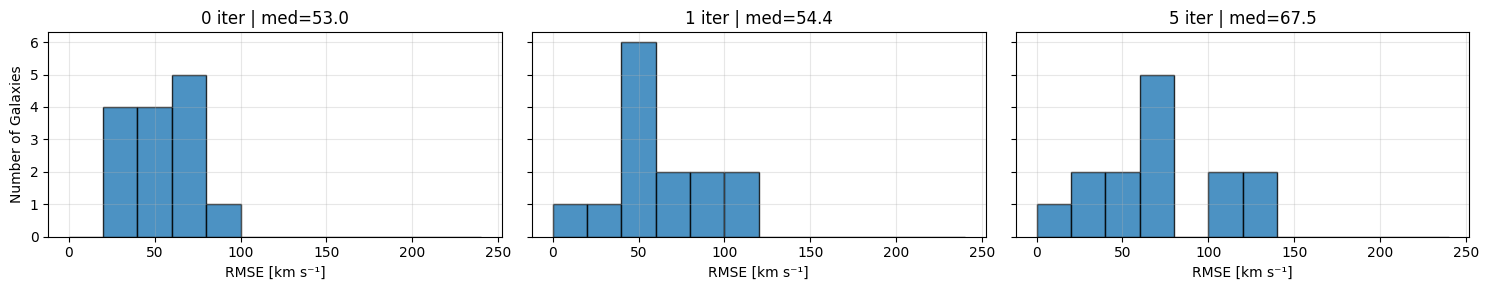

In [1]:
# ============  Thin-disc iteration-depth test (final parser) ==========
#   Needs  table1.dat  &  table2.dat  in  /content/DATA
# =====================================================================

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

DATA_DIR   = '/content/DATA'
META_FILE  = f'{DATA_DIR}/table1.dat'
CURVE_FILE = f'{DATA_DIR}/table2.dat'

# ---------- 1. metadata with correct Vflat span ----------------------
meta = pd.read_fwf(
    META_FILE,
    colspecs=[(0,11), (12,14), (30,34), (56,61), (100,106), (112,115)],
    names=['Galaxy','Morph','Incl','Rdisk','Vflat','Qual']
)
meta['Morph'] = meta['Morph'].fillna('').astype(str).str.strip().str.lower()
for c in ['Incl','Rdisk','Vflat','Qual']:
    meta[c] = pd.to_numeric(meta[c], errors='coerce')

EXCL = ['im','irr','pec','ib','int']
meta['unsuitable'] = meta.apply(
    lambda r: (any(k in r['Morph'] for k in EXCL) or r['Incl']<30 or r['Qual']>2),
    axis=1
)

disc_flag = (~meta['unsuitable']) & (meta['Incl']>=70) & (meta['Vflat']>=180)
disc_set  = set(meta.loc[disc_flag,'Galaxy'])
print(f'ℹ️  Massive, edge-on discs found: {sorted(disc_set)}\n')

# ---------- 2. rotation curves --------------------------------------
curves = pd.read_table(
    CURVE_FILE, sep=r'\s+', comment='#', header=None,
    usecols=[0,2,3,5,6,7],
    names=['Galaxy','r','Vobs','Vgas','Vdisk','Vbul']
)
curves = curves[curves['Galaxy'].isin(disc_set)].copy()
cols = ['r','Vobs','Vgas','Vdisk','Vbul']
curves[cols] = curves[cols].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r','Vobs'], inplace=True)

print("Points per disc galaxy:")
for gal, npts in curves.groupby('Galaxy').size().items():
    print(f"  {gal:<10} : {npts} points")
print()

# ---------- 3. WILL solver ------------------------------------------
DISC_LAM = 0.45
def will_v(df, depth):
    vb_sq = df['Vgas']**2 + df['Vdisk']**2 + df['Vbul']**2
    v_sq  = vb_sq.copy()
    if depth==0:
        return np.sqrt(np.clip(v_sq,0,None))
    nz = df['r']>0
    for _ in range(depth):
        integ = cumulative_trapezoid(v_sq, df['r'], initial=0.0)
        geom  = np.zeros_like(v_sq)
        geom[nz] = DISC_LAM*integ[nz]/df.loc[nz,'r']
        v_sq = vb_sq + geom
    return np.sqrt(np.clip(v_sq,0,None))

# ---------- 4. RMSE for depths 0,1,5 --------------------------------
MIN_POINTS = 3
results={}
for depth in [0,1,5]:
    rec=[]
    for gal,gdf in curves.groupby('Galaxy'):
        if len(gdf) < MIN_POINTS: continue
        rmse = np.sqrt(
            np.mean((gdf['Vobs'] - will_v(gdf.sort_values('r'), depth))**2))
        rec.append({'Galaxy':gal,'RMSE':rmse})
    if rec:
        results[depth] = pd.DataFrame(rec).set_index('Galaxy')

if not results:
    print("❌ No galaxy met the point threshold. "
          "Try lowering MIN_POINTS if data are very sparse.")
else:
    # ---------- 5. summary -------------------------------------------
    summary = pd.DataFrame({
        'Median_RMSE'   : [results[d]['RMSE'].median()    for d in [0,1,5]],
        '90th_pct_RMSE' : [results[d]['RMSE'].quantile(0.9) for d in [0,1,5]]
    }, index=['0 iter','1 iter','5 iter']).rename_axis('Depth')

    print('\n=====  Thin-disc RMSE vs Iteration Depth =====')
    display(summary)

    # ---------- 6. per-galaxy table ----------------------------------
    cmp = (results.get(0,pd.DataFrame())
           .join(results.get(1,pd.DataFrame()),lsuffix='_0',rsuffix='_1')
           .join(results.get(5,pd.DataFrame()),rsuffix='_5')
           .rename(columns={'RMSE':'RMSE_5'}))
    display(cmp)

    # ---------- 7. histograms ----------------------------------------
    fig,axes = plt.subplots(1,len(results), figsize=(5*len(results),3), sharey=True)
    if len(results)==1: axes=[axes]
    bins=np.arange(0,260,20)
    for ax,(d,df) in zip(axes,results.items()):
        ax.hist(df['RMSE'], bins=bins, edgecolor='k', alpha=0.8)
        ax.set_title(f'{d} iter | med={df.RMSE.median():.1f}')
        ax.set_xlabel('RMSE [km s⁻¹]')
        ax.grid(alpha=0.3)
    axes[0].set_ylabel('Number of Galaxies')
    plt.tight_layout(); plt.show()


=====  WILL 3.0 : adaptive depth results =====
Galaxies analysed : 175
Median RMSE [km/s]: 25.89
90-th pct RMSE    : 86.92



,Depth,RMSE
Galaxy,,
UGC07577,5,2.532732
UGC09992,5,3.467564
UGC07690,5,3.741024
NGC4068,5,4.196779
UGCA281,5,4.251212
UGC07559,5,4.260800
F563-V1,5,4.364849
UGC07323,5,4.474007
UGC04483,5,5.006883


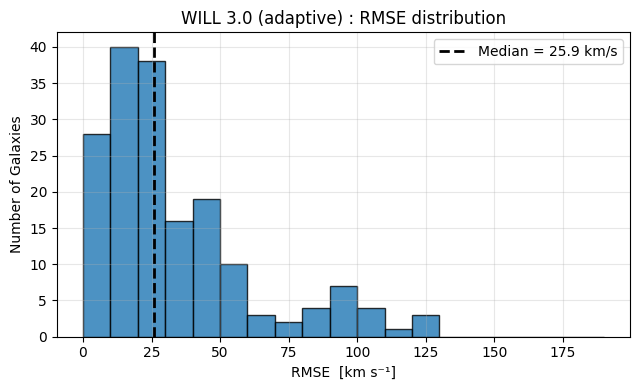

In [2]:
# ============  WILL 3.0 : adaptive onion depth  ======================
#   Works with table1.dat / table2.dat  in  /content/DATA
# ====================================================================

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

DATA = '/content/DATA'
META = f'{DATA}/table1.dat'
CURV = f'{DATA}/table2.dat'

# ----- 1. metadata ---------------------------------------------------
meta = pd.read_fwf(
    META,
    colspecs=[(0,11),(12,14),(30,34),(56,61),(72,76),
              (94,99),(100,106),(112,115)],
    names=['Galaxy','Morph','Incl','Rdisk','BT','R25','Vflat','Qual']
)
meta['Morph'] = meta['Morph'].fillna('').astype(str).str.strip().str.lower()
for c in ['Incl','Rdisk','BT','R25','Vflat','Qual']:
    meta[c] = pd.to_numeric(meta[c], errors='coerce')

# geometry class → depth
def choose_depth(row):
    if row['Incl']>=70 and row['Vflat']>=180:
        bt = row['BT'] if not np.isnan(row['BT']) else 0.0
        return 0 if bt<0.1 else 1
    return 5

meta['Depth'] = meta.apply(choose_depth, axis=1)

# ----- 2. curves -----------------------------------------------------
curves = pd.read_table(
    CURV, sep=r'\s+', comment='#', header=None,
    usecols=[0,2,3,5,6,7],
    names=['Galaxy','r','Vobs','Vgas','Vdisk','Vbul']
)
cols = ['r','Vobs','Vgas','Vdisk','Vbul']
curves[cols] = curves[cols].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r','Vobs'], inplace=True)

# ----- 3. solver -----------------------------------------------------
DISC_LAM = 0.45
def will_v(df, depth):
    vb_sq = df['Vgas']**2 + df['Vdisk']**2 + df['Vbul']**2
    v_sq  = vb_sq.copy()
    if depth==0:
        return np.sqrt(np.clip(v_sq,0,None))
    nz=df['r']>0
    for _ in range(depth):
        integ = cumulative_trapezoid(v_sq, df['r'], initial=0.0)
        geom  = np.zeros_like(v_sq)
        geom[nz] = DISC_LAM*integ[nz]/df.loc[nz,'r']
        v_sq = vb_sq + geom
    return np.sqrt(np.clip(v_sq,0,None))

# ----- 4. run model on entire catalogue ------------------------------
records=[]
for gal,gdf in curves.groupby('Galaxy'):
    depth = int(meta.loc[meta['Galaxy']==gal,'Depth'].values[0])
    if len(gdf)<3: continue
    rmse = np.sqrt(np.mean(
        (gdf['Vobs'] - will_v(gdf.sort_values('r'), depth))**2))
    records.append({'Galaxy':gal,'Depth':depth,'RMSE':rmse})

df = pd.DataFrame(records).set_index('Galaxy').sort_values('RMSE')

# ----- 5. report -----------------------------------------------------
print("\n=====  WILL 3.0 : adaptive depth results =====")
print(f"Galaxies analysed : {len(df)}")
print(f"Median RMSE [km/s]: {df.RMSE.median():.2f}")
print(f"90-th pct RMSE    : {df.RMSE.quantile(0.9):.2f}\n")
display(df.head(20))

plt.figure(figsize=(6.5,4))
plt.hist(df.RMSE,bins=np.arange(0,200,10),edgecolor='k',alpha=0.8)
plt.axvline(df.RMSE.median(),ls='--',lw=2,c='k',
            label=f"Median = {df.RMSE.median():.1f} km/s")
plt.xlabel('RMSE  [km s⁻¹]'); plt.ylabel('Number of Galaxies')
plt.title('WILL 3.0 (adaptive) : RMSE distribution')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


=====  WILL 3.1 : λ-corrected adaptive depth =====
Galaxies analysed : 175
Median RMSE [km/s]: 20.12
90-th pct RMSE    : 175.93



,Class,Depth,RMSE
Galaxy,,,
UGCA281,other,5,1.175924
UGC04483,other,5,1.386352
UGC07866,other,5,1.545150
UGC05414,other,5,1.631349
UGC07559,other,5,1.731612
UGC04499,other,5,2.246902
UGC08490,other,5,2.400484
F583-4,other,5,2.711779
KK98-251,other,5,3.097666


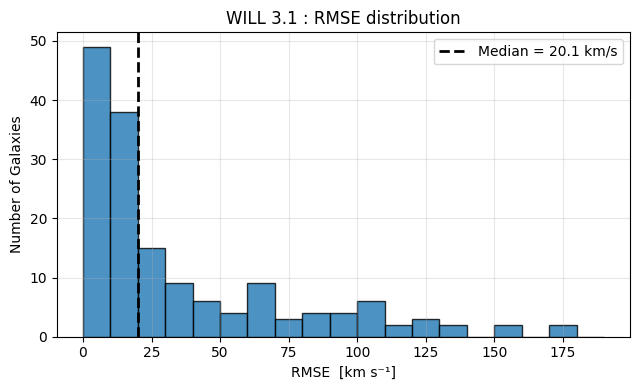

In [3]:
# ============  WILL 3.1 : correct λ per geometry =====================
#  Works with table1.dat & table2.dat in /content/DATA
# ====================================================================

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.integrate import cumulative_trapezoid

DATA = '/content/DATA'
META = f'{DATA}/table1.dat'
CURV = f'{DATA}/table2.dat'

# ---------- metadata -------------------------------------------------
meta = pd.read_fwf(
    META,
    colspecs=[(0,11),(12,14),(30,34),(56,61),(94,99),(100,106),(112,115)],
    names=['Galaxy','Morph','Incl','Rdisk','BT','Vflat','Qual']
)
meta['Morph'] = meta['Morph'].fillna('').astype(str).str.strip().str.lower()
for c in ['Incl','Rdisk','BT','Vflat','Qual']:
    meta[c] = pd.to_numeric(meta[c], errors='coerce')

EXCL = ['im','irr','pec','ib','int']
meta['unsuit'] = meta.apply(
    lambda r: (any(k in r['Morph'] for k in EXCL) or r['Incl']<30 or r['Qual']>2),
    axis=1
)

def geo_class(r):
    if r['unsuit']: return 'other'
    if r['Incl']>=70 and r['Vflat']>=180:
        bt = r['BT'] if not np.isnan(r['BT']) else 0.0
        return 'disc0' if bt<0.1 else 'disc1'
    return 'other'

meta['Class'] = meta.apply(geo_class, axis=1)
depth_map = {'disc0':0, 'disc1':1, 'other':5}
lambda_map = {'disc0':0.45, 'disc1':0.45, 'other':1.0}

# ---------- curves ---------------------------------------------------
curves = pd.read_table(
    CURV, sep=r'\s+', comment='#', header=None,
    usecols=[0,2,3,5,6,7],
    names=['Galaxy','r','Vobs','Vgas','Vdisk','Vbul']
)
num = ['r','Vobs','Vgas','Vdisk','Vbul']
curves[num] = curves[num].apply(pd.to_numeric, errors='coerce')
curves.dropna(subset=['r','Vobs'], inplace=True)

# ---------- solver ---------------------------------------------------
def will_v(df, depth, lam):
    vb_sq = df['Vgas']**2 + df['Vdisk']**2 + df['Vbul']**2
    v_sq  = vb_sq.copy()
    if depth==0:
        return np.sqrt(np.clip(v_sq,0,None))
    nz = df['r']>0
    for _ in range(depth):
        integ = cumulative_trapezoid(v_sq, df['r'], initial=0.0)
        geom  = np.zeros_like(v_sq)
        geom[nz] = lam*integ[nz]/df.loc[nz,'r']
        v_sq = vb_sq + geom
    return np.sqrt(np.clip(v_sq,0,None))

# ---------- run catalogue --------------------------------------------
rows=[]
for gal,gdf in curves.groupby('Galaxy'):
    cls   = meta.loc[meta['Galaxy']==gal,'Class'].values[0]
    depth = depth_map[cls]
    lam   = lambda_map[cls]
    if len(gdf)<3: continue
    rmse = np.sqrt(np.mean(
        (gdf['Vobs'] - will_v(gdf.sort_values('r'),depth,lam))**2))
    rows.append({'Galaxy':gal,'Class':cls,'Depth':depth,'RMSE':rmse})

df = pd.DataFrame(rows).set_index('Galaxy').sort_values('RMSE')

# ---------- report ---------------------------------------------------
print("\n=====  WILL 3.1 : λ-corrected adaptive depth =====")
print(f"Galaxies analysed : {len(df)}")
print(f"Median RMSE [km/s]: {df.RMSE.median():.2f}")
print(f"90-th pct RMSE    : {df.RMSE.quantile(0.9):.2f}\n")
display(df.head(20))

plt.figure(figsize=(6.5,4))
plt.hist(df.RMSE,bins=np.arange(0,200,10),edgecolor='k',alpha=0.8)
plt.axvline(df.RMSE.median(),ls='--',lw=2,c='k',
            label=f"Median = {df.RMSE.median():.1f} km/s")
plt.xlabel('RMSE  [km s⁻¹]'); plt.ylabel('Number of Galaxies')
plt.title('WILL 3.1 : RMSE distribution')
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()